# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:50px;padding:20px 10px;font-weight:bold">Urban Sound Classification <p/> 

## The data can be found here: [UrbanSound8K](https://urbansounddataset.weebly.com/download-urbansound8k.html)

In [155]:
# Libraries for Audio data
import IPython.display as ipd
import librosa
import librosa.display

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Math and Dataframes
import pandas as pd
import numpy as np

# ML
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
from scikeras.wrappers import KerasClassifier

from datetime import datetime 
import os
from tqdm import tqdm

# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Sample Sound File <p/> 

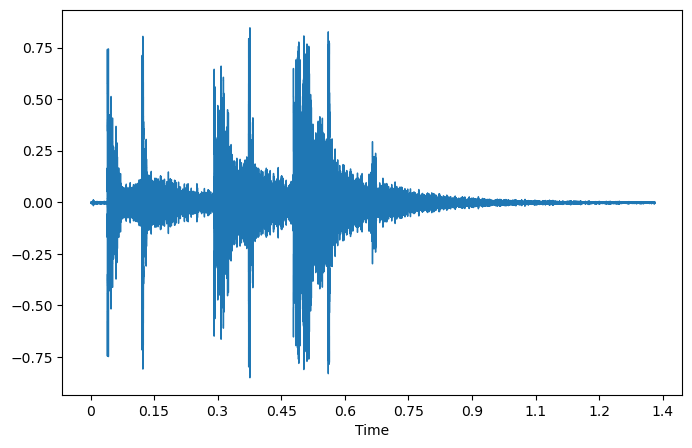

In [177]:
filepath = "audio/fold4/7064-6-4-0.wav"

plt.figure(figsize=(8,5))

data, sample_rate = librosa.load(filepath)

librosa.display.waveshow(data, sr = sample_rate)

ipd.Audio(filepath)

# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Metadata <p/>

In [26]:
# Read metadata into a dataframe
metadata = pd.read_csv('UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [28]:
# We can check to see what the class of our sample audio is: gun_shot
metadata.query('slice_file_name == "7064-6-4-0.wav"')

,slice_file_name,fsID,start,end,salience,fold,classID,class
7383,7064-6-4-0.wav,7064,5.952204,7.283618,1,4,6,gun_shot


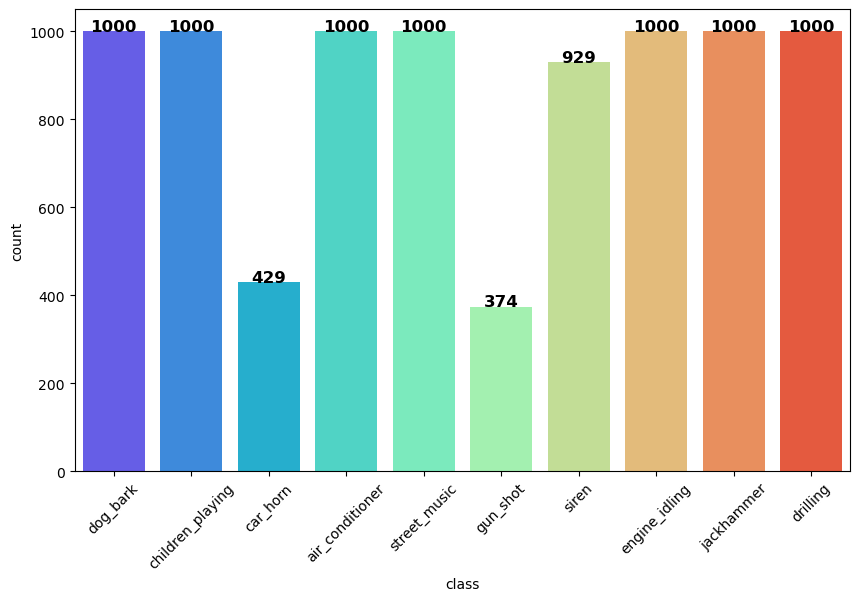

In [38]:
# Check for class imbalance
plt.figure(figsize=(10,6))

ax = sns.countplot(x='class', data=metadata, palette='rainbow')

plt.xticks(rotation=45)

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-.4, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                verticalalignment = 'baseline',
                size='large') 
plt.show()

# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Data Preprocessing <p/>

Audio can be recorded at different rates, like 44KHz or 22KHz. We will use librosa to normalize the data to all be 22KHz. We will then use librosa to extract the MFCCs to be our features for predicting the class.

MFCCs – The MFCC summarizes the frequency distribution across the window size. So, it is possible to analyze both the frequency and time characteristics of the sound. This audio representation will allow us to identify features for classification. So, it will try to convert audio into some kind of features based on time and frequency characteristics that will help us to do classification

In [39]:
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)
print(mfccs)

(40, 58)
[[-3.1985980e+02 -6.3617027e+01 -6.5992727e+00 ... -4.4676675e+02
  -4.4978809e+02 -4.6586389e+02]
 [ 7.4179367e+01  6.7636398e+01  6.1466423e+01 ...  1.0243866e+02
   1.0492354e+02  9.7078995e+01]
 [ 1.2957064e+01  2.4930676e+01  2.5639053e+01 ... -6.6639671e+00
   4.2075098e-02  5.7045841e+00]
 ...
 [-6.7663383e-01  3.0605507e+00  9.5068836e-01 ...  2.3821335e+00
   3.4469991e+00  1.8466721e+00]
 [-3.5622334e+00 -7.2183638e+00 -8.6647406e+00 ...  6.0995579e-01
   2.3074102e+00  2.9438660e+00]
 [ 2.5559416e+00  1.8702772e+00  1.5161220e+00 ...  2.2323823e-01
   1.7317420e+00  1.6931818e+00]]


In [40]:
def features_extractor(file):
    
    #load the audio file 
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    
    #extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    #in order to find oue scaled features we calculate the mean of the transpose
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [54]:
# Now we need to extract the features from all the audio files in a for-loop
# Note: This has been commented out since I have already run this and saved it to a csv

#extracted_features=[]
#
#audio_dataset_path='audio/'
#
#for index_num,row in tqdm(metadata.iterrows()):
#    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
#    final_class_labels=row["class"]
#    data=features_extractor(file_name)
#    extracted_features.append([data,final_class_labels])

3554it [05:20,  8.87it/s]/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8326it [11:36, 21.63it/s]/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [12:05, 12.04it/s]


In [55]:
#Converting extracted_features to a dataframe

#extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
#extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [57]:
# Save to csv if needed for future use (so we don't need to re-run the for-loop)

#extracted_features_df.to_csv('extracted_features.csv')

In [146]:
df = pd.read_csv('extracted_features.csv').reset_index(drop=True)
df = df.drop('Unnamed: 0',axis=1)
df.head()

,feature,class
0,[-217.35526 70.22338 -130.38527 -5...,dog_bark
1,[-4.2409818e+02 1.0934077e+02 -5.2919525e+01 ...,children_playing
2,[-4.5879114e+02 1.2138419e+02 -4.6520657e+01 ...,children_playing
3,[-413.89984 101.66373 -35.42945 5...,children_playing
4,[-4.4660352e+02 1.1368541e+02 -5.2402206e+01 ...,children_playing


# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Model Creation <p/>

In [147]:
# Create features variable
X = np.array(extracted_features_df['feature'].tolist())

# Create target variable
y = np.array(extracted_features_df['class'].tolist())


# Transform target variable into dummies
labelencoder=LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

# Train/Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)



In [160]:
# Number of classes: 10
num_labels = y.shape[1]


model = Sequential()

#First layer
model.add(Dense(512,input_shape=(40,), kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

#Second layer
model.add(Dense(256,kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

#Third layer
model.add(Dense(64,kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

#Final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [161]:
#Define the loss function, the optimizer and the metric
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [162]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)


start = datetime.now()

history = model.fit(X_train,
          y_train,
          batch_size=num_batch_size,
          epochs=num_epochs,
          validation_data=(X_test, y_test),
          callbacks=[checkpointer],
          verbose=1)

duration = datetime.now() - start

print("Training completed in time: ", duration)

Epoch 1/100
217/219 [============================>.] - ETA: 0s - loss: 3.7455 - accuracy: 0.1488
Epoch 00001: val_loss improved from inf to 2.55285, saving model to ./audio_classification.hdf5
219/219 [==============================] - 2s 6ms/step - loss: 3.7386 - accuracy: 0.1489 - val_loss: 2.5529 - val_accuracy: 0.1986
Epoch 2/100
208/219 [===========================>..] - ETA: 0s - loss: 2.5536 - accuracy: 0.2172
Epoch 00002: val_loss improved from 2.55285 to 2.41769, saving model to ./audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.5539 - accuracy: 0.2179 - val_loss: 2.4177 - val_accuracy: 0.2519
Epoch 3/100
214/219 [============================>.] - ETA: 0s - loss: 2.4102 - accuracy: 0.2661
Epoch 00003: val_loss improved from 2.41769 to 2.21751, saving model to ./audio_classification.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 2.4078 - accuracy: 0.2659 - val_loss: 2.2175 - val_accuracy: 0.3303
Epoch 4/100
218/219 

219/219 [==============================] - 1s 6ms/step - loss: 0.8527 - accuracy: 0.8084 - val_loss: 0.7907 - val_accuracy: 0.8472
Epoch 27/100
213/219 [============================>.] - ETA: 0s - loss: 0.8513 - accuracy: 0.8059
Epoch 00027: val_loss improved from 0.79070 to 0.77865, saving model to ./audio_classification.hdf5
219/219 [==============================] - 1s 6ms/step - loss: 0.8527 - accuracy: 0.8066 - val_loss: 0.7787 - val_accuracy: 0.8403
Epoch 28/100
219/219 [==============================] - ETA: 0s - loss: 0.8489 - accuracy: 0.8176
Epoch 00028: val_loss did not improve from 0.77865
219/219 [==============================] - 1s 6ms/step - loss: 0.8489 - accuracy: 0.8176 - val_loss: 0.7877 - val_accuracy: 0.8569
Epoch 29/100
219/219 [==============================] - ETA: 0s - loss: 0.8211 - accuracy: 0.8229
Epoch 00029: val_loss improved from 0.77865 to 0.76183, saving model to ./audio_classification.hdf5
219/219 [==============================] - 2s 7ms/step - loss:

Epoch 54/100
217/219 [============================>.] - ETA: 0s - loss: 0.7189 - accuracy: 0.8605
Epoch 00054: val_loss did not improve from 0.63905
219/219 [==============================] - 1s 6ms/step - loss: 0.7187 - accuracy: 0.8603 - val_loss: 0.6867 - val_accuracy: 0.8930
Epoch 55/100
207/219 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.8718
Epoch 00055: val_loss did not improve from 0.63905
219/219 [==============================] - 1s 6ms/step - loss: 0.6870 - accuracy: 0.8723 - val_loss: 0.7291 - val_accuracy: 0.8792
Epoch 56/100
216/219 [============================>.] - ETA: 0s - loss: 0.7078 - accuracy: 0.8692
Epoch 00056: val_loss did not improve from 0.63905
219/219 [==============================] - 1s 4ms/step - loss: 0.7072 - accuracy: 0.8693 - val_loss: 0.7215 - val_accuracy: 0.8718
Epoch 57/100
210/219 [===========================>..] - ETA: 0s - loss: 0.7181 - accuracy: 0.8641
Epoch 00057: val_loss did not improve from 0.63905
219/219 [==

215/219 [============================>.] - ETA: 0s - loss: 0.6783 - accuracy: 0.8789
Epoch 00083: val_loss did not improve from 0.63905
219/219 [==============================] - 2s 11ms/step - loss: 0.6788 - accuracy: 0.8783 - val_loss: 0.6759 - val_accuracy: 0.8975
Epoch 84/100
214/219 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.8823
Epoch 00084: val_loss did not improve from 0.63905
219/219 [==============================] - 2s 10ms/step - loss: 0.6772 - accuracy: 0.8829 - val_loss: 0.6882 - val_accuracy: 0.8907
Epoch 85/100
213/219 [============================>.] - ETA: 0s - loss: 0.6610 - accuracy: 0.8864
Epoch 00085: val_loss did not improve from 0.63905
219/219 [==============================] - 2s 7ms/step - loss: 0.6600 - accuracy: 0.8863 - val_loss: 0.6545 - val_accuracy: 0.8998
Epoch 86/100
215/219 [============================>.] - ETA: 0s - loss: 0.6572 - accuracy: 0.8810
Epoch 00086: val_loss did not improve from 0.63905
219/219 [=============

In [163]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.tight_layout()
    plt.show()

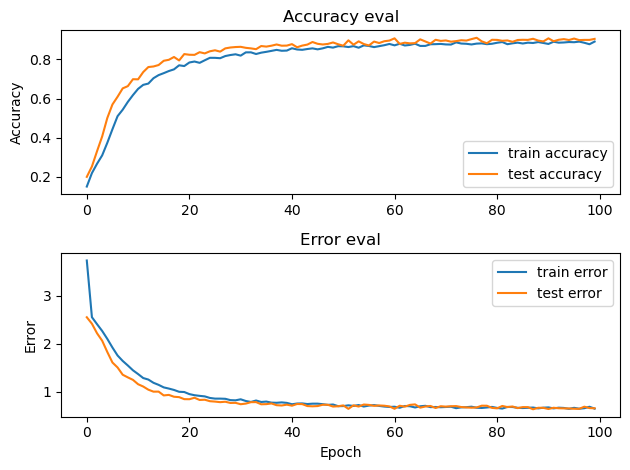

In [164]:
plot_history(history)

In [165]:
# Test Accuracy

test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print('Test Accuracy: ',test_accuracy[1])

Test Accuracy:  0.9055523872375488


In [166]:
# Get model predictions for test set
y_pred=model.predict(X_test)

In [167]:
# Convert predictions into a list of numbers 0-9
y_pred_label = np.argmax(y_pred,axis=1)
print('Predicted Labels: ',y_pred_label[:6])

# Convert predictions into actual class name
y_pred_names = labelencoder.inverse_transform(y_pred_label) 
print('Predicted Names: ',y_pred_names[:6])

print('-----------------------------------------------------------------')

y_test_labels = np.argmax(y_test, axis=1)
print('Actual Labels: ',y_test_labels[:6])

y_test_names = labelencoder.inverse_transform(y_test_labels) 
print('Actual Names',y_test_names[:6])

Predicted Labels:  [8 9 4 8 3 7]
Predicted Names:  ['siren' 'street_music' 'drilling' 'siren' 'dog_bark' 'jackhammer']
-----------------------------------------------------------------
Actual Labels:  [8 9 4 8 3 7]
Actual Names ['siren' 'street_music' 'drilling' 'siren' 'dog_bark' 'jackhammer']


In [120]:
# Codes for Labels

# 0 = air_conditioner
# 1 = car_horn'
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

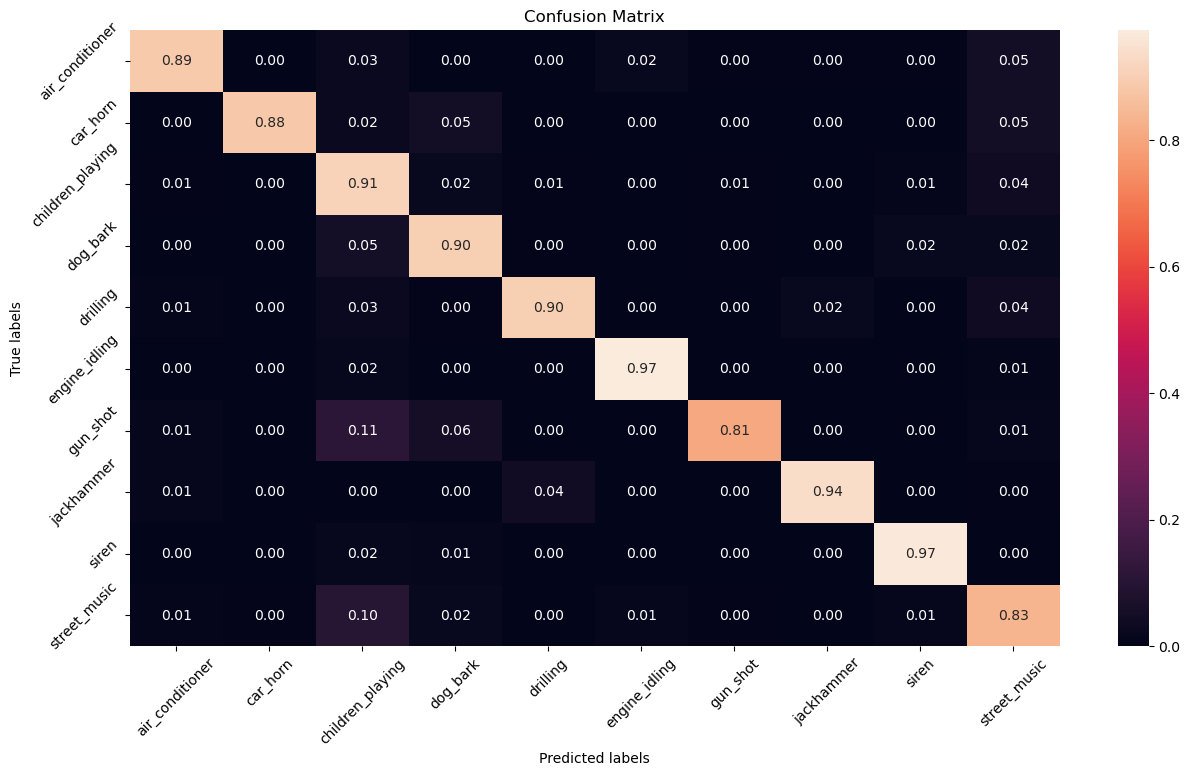

In [168]:
# Heatmap of the confusion matrix

labels = ['air_conditioner','car_horn','children_playing','dog_bark',
          'drilling','engine_idling','gun_shot','jackhammer','siren',
          'street_music']

cm = confusion_matrix(y_test_names, y_pred_names, labels=labels,normalize='true')


plt.figure(figsize=(15,8))
ax = sns.heatmap(cm, annot=True, fmt='.2f')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [173]:
# Cross-Validation

#keras_clf = KerasClassifier(model = model, optimizer="adam", epochs=100, verbose=0)
#
#accuracies = cross_val_score(estimator=keras_clf,
#                             X = X_train,
#                             y = y_train,
#                             cv= 10,
#                             scoring ='accuracy')
#
#mean = accuracies.mean()
#variance = accuracies.std()
#
#print(mean)
#print(variance)

#predictions = cross_val_predict(keras_clf, X_train, y_train, cv=3)

2022-11-23 09:24:44.100440: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmpbsknzwrm/assets
INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmpoxygp6qi/assets
INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmpwcdecejy/assets
INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmpz4y1du5r/assets
INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmplxg53r3d/assets
INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmptplnmx2j/assets
INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmph3f_l2gd/assets
INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmpx5sp41ih/assets
INFO:tensorflow:Assets written to: ram:///var/folders/hv/tr02jvzs0qd7pmfzfhq48sr80000gn/T/tmpfo20_we8/assets
INFO:tensorflow:Ass

# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Testing the Model on a Sample <p/>

In [186]:
filename="audio/fold8/7390-9-0-3.wav"

audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)


mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)

predicted_label=model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted_label,axis=1)
print(predicted_label)

prediction_class = labelencoder.inverse_transform(predicted_label) 
print(prediction_class)

ipd.Audio(filename)

[9]
['street_music']


# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Results<p/>

* The model has an accuracy of 89% on the training set and 90% on the test set.
* The indiviudal accuracies are:
    * air_conditioner: 89%
    * car_horn: 88%
    * children_playing: 91%
    * dog_bark: 90%
    * drilling: 90%
    * engine_idling: 97%
    * gun_shot: 81%
    * jackhammer: 94%
    * siren: 97%
    * street_music: 83%